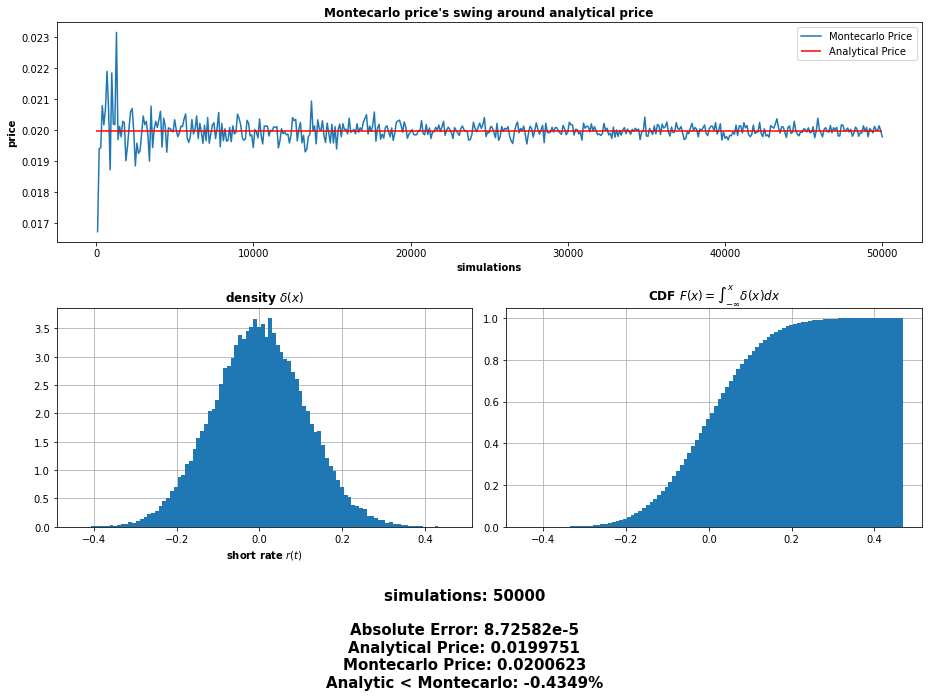

In [5]:
import numpy as np
from scipy.stats import norm
from numpy import exp
from matplotlib import pyplot as plt

# data ------------------------------------------------------------------------

r0=0.015
k=0.25
theta=0.02
sigma=0.1
T_fix=2
T_pay=2.5
t=0
w=1
strike=0.005
Nom=1

# parameters ------------------------------------------------------------------

def B(t,T,k):
    return ( 1-exp(-k*(T-t)) )/k

def A(t,T,k,sigma,theta):
    return exp( (theta-sigma**2/(2*k**2))*(B(t,T,k)-(T-t))-sigma**2/(4*k)*B(t,T,k)**2 )

def P(t,T,k,r0,sigma,theta):
    return A(t,T,k,sigma,theta)*exp(-B(t,T,k)*r0)

def MT(t,T_fix,T_pay,k,sigma,theta):
    return (k*theta-sigma**2/k)*B(t,T_fix,k)+sigma**2/(2*k)*(B(t-T_fix,T_pay-t,k)-B(T_fix,T_pay,k))


# ZCBO_price ------------------------------------------------------------------

def ZCBO_price(t,T_fix,T_pay,strike,r0,k,sigma,theta,w):
    
    P0f=P(t,T_fix,k,r0,sigma,theta)
    P0p=P(t,T_pay,k,r0,sigma,theta)
    Pfp=P0p/P0f
    Bfp=B(T_fix,T_pay,k)
    B0f=B(t,T_fix,2*k)
    
    
    sigmaB=sigma*Bfp*np.sqrt(B0f)
    dB= (np.log( Pfp/strike ) + 1/2*sigmaB**2 )/sigmaB
    
    d1=w*dB
    d2=w*(dB-sigmaB)
    
    return P0f*w*( Pfp*norm.cdf(d1)-strike*norm.cdf(d2) )

# Analytical price ------------------------------------------------------------

def CAPLET_price(t,T_fix,T_pay,Nom,strike,r0,k,sigma,theta,w):
    
    w_mod= -w
    strike_mod= 1/(1+strike*(T_pay-T_fix))
    
    return ZCBO_price(t,T_fix,T_pay,strike_mod,r0,k,sigma,theta,w_mod)/strike_mod

# Montecarlo price ------------------------------------------------------------

n_sim=50000

def short_rate_MC(t,T_fix,T_pay,r0,n_sim,strike,k,theta,sigma):
    
    Mt=MT(t,T_fix,T_pay,k,sigma,theta)
    
    Z=np.random.normal(0,1,n_sim)
    drift_t=r0*(1-k*B(t,T_fix,k))+Mt
    diffusion_t=sigma*np.sqrt(B(t,T_fix,2*k))
    
    r_t=drift_t+diffusion_t*Z
    
    DF=P(T_fix,T_pay,k,r_t,sigma,theta)
    P0p=P(t,T_pay,k,r0,sigma,theta)
    
    Libor=(1/DF - 1)/(T_pay-T_fix)
    
    payoffs=np.maximum(Libor-strike,0)
    
    return r_t,Nom*(T_pay-T_fix)*P0p*np.mean(payoffs)

# -----------------------------------------------------------------------------

[r_t,caplet_price_MC]=short_rate_MC(t,T_fix,T_pay,r0,n_sim,strike,k,theta,sigma)
caplet_price_AL=CAPLET_price(t,T_fix,T_pay,Nom,strike,r0,k,sigma,theta,w)

#print("Analytical price:",
#      caplet_price_AL,
#      "\n"+"Montecarlo Price:",
#     caplet_price_MC
#      )

# plot ------------------------------------------------------------------------

fig=plt.figure(figsize=(13,8))

sp1=fig.add_subplot(2,2,3)
sp1.grid(True)

sp2=fig.add_subplot(2,2,4)
sp2.grid(True)

hist=sp1.hist(r_t,bins=100,density=True,zorder=2)
sp1.set_title("density $\delta(x)$",weight="bold")
sp1.set_xlabel("short rate $r(t)$",weight="bold")

sp2.hist(r_t,bins=100,density=True,cumulative=True,zorder=2)
sp2.set_title("CDF $F(x)=\int_{-\infty}^{x}\delta(x)dx$",weight="bold")

var_perc=round((caplet_price_AL-caplet_price_MC)/(caplet_price_MC)*100,4)
comparison_str=">" if var_perc > 0 else "<"

fig.text(0.5,-0.2,
         f"simulations: {n_sim}"+
         "\n \n"+
         f"Absolute Error: {round(abs( (caplet_price_AL-caplet_price_MC)*10**5),5)}"+"e-5"+
         "\n"
         f"Analytical Price: {round(caplet_price_AL,7)}"+
         "\n"+
         f"Montecarlo Price: {round(caplet_price_MC,7)}"+
         "\n"+
         f"Analytic {comparison_str} Montecarlo: {var_perc}%",
         weight="bold",size=15,ha="center"
         )

caplet_prices_MC=list()
simulations= range(100,n_sim+1,100)

for sim in simulations:
    caplet_prices_MC+= [ short_rate_MC(t, T_fix, T_pay, r0, sim, strike, k, theta, sigma)[1] ]

sp3=fig.add_subplot(2,1,1)

sp3.plot(simulations,caplet_prices_MC)
sp3.hlines(caplet_price_AL,xmin=0,xmax=n_sim,color="red")

sp3.set_xlabel("simulations",weight="bold")
sp3.set_ylabel("price",weight="bold")
sp3.set_title("Montecarlo price's swing around analytical price",weight="bold")
sp3.legend(["Montecarlo Price","Analytical Price"])

fig.tight_layout()


#fig2=plt.figure(figsize=(13,8))
#ax=fig2.add_axes([0,0,1,1])

#ax.plot(simulations,caplet_prices_MC)
#ax.hlines(caplet_price_AL,xmin=0,xmax=n_sim,color="red",linewidth=2)

#ax.set_xlabel("simulazioni",weight="bold")
#ax.set_ylabel("prezzo",weight="bold")
#ax.set_title("oscillazione del prezzo Montecarlo attorno al prezzo Analitico",weight="bold")
#ax.legend(["prezzo Montecarlo","prezzo Analotico"])

